# Import necessary libraries


In [1]:
import pandas as pd
import nltk
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Load the dataset
Display the first few rows of the dataset


In [5]:
file_path = r"C:\Users\NTC\Downloads\reviews_data.csv"


df = pd.read_csv(file_path)


df.head()

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...





# Preprocessing
 Download necessary NLTK data


In [9]:
nltk.download('stopwords')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NTC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\NTC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:

def preprocess_text(text):
    # Remove punctuation and lower case
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text


df['Cleaned_Review'] = df['Review'].apply(preprocess_text)

# Sentiment Analysis


In [11]:
sid = SentimentIntensityAnalyzer()


def get_sentiment(text):
    scores = sid.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'


df['Sentiment'] = df['Cleaned_Review'].apply(get_sentiment)

# Visualization of Sentiment Distribution


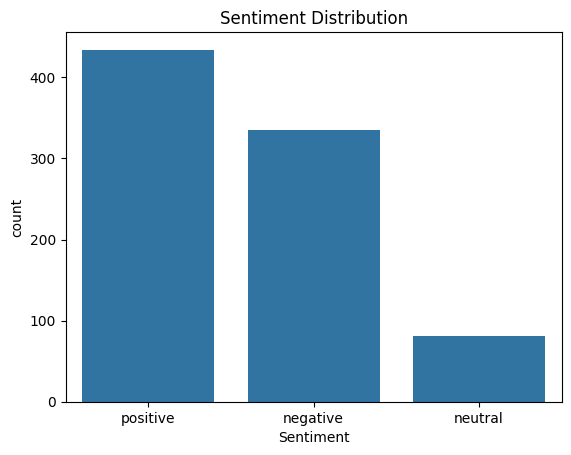

In [12]:
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()








# Consumer Insights
 Extract common complaints and positive experiences


In [13]:
positive_reviews = df[df['Sentiment'] == 'positive']['Cleaned_Review']
negative_reviews = df[df['Sentiment'] == 'negative']['Cleaned_Review']

Word Clouds

In [14]:

positive_wordcloud = WordCloud(
    width=800, height=400, background_color='white').generate(' '.join(positive_reviews))
negative_wordcloud = WordCloud(width=800, height=400, background_color='black',
                               colormap='Reds').generate(' '.join(negative_reviews))

Plot Word Clouds

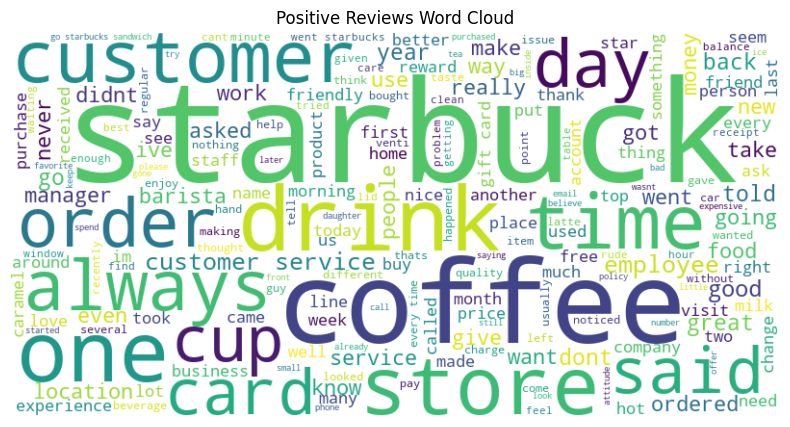

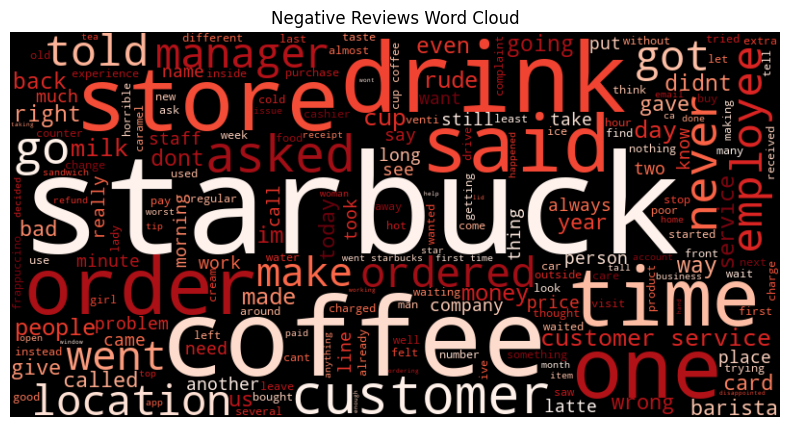

In [15]:



plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()




# Explore correlations between ratings, sentiments, and reviewer demographics
Assuming ratings are on a scale of 1-5


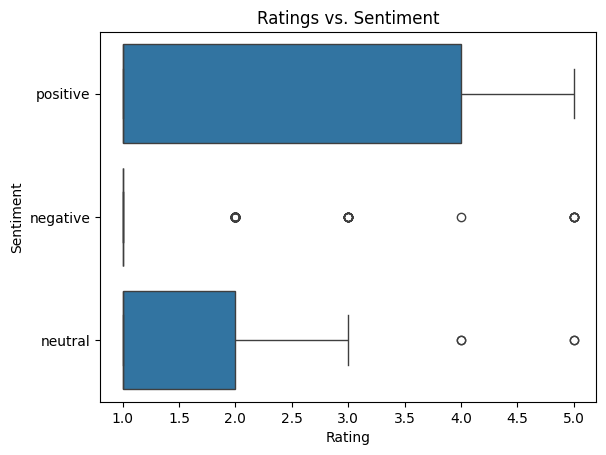

In [16]:
sns.boxplot(x='Rating', y='Sentiment', data=df)
plt.title('Ratings vs. Sentiment')
plt.show()

 Topic Modeling using LDA



In [17]:
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['Cleaned_Review'])

LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

Display the top words for each topic


In [18]:
for i, topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names_out()[i]
          for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['went', 'location', 'store', 'said', 'cup', 'time', 'order', 'drink', 'starbucks', 'coffee']


Top 10 words for topic #1:
['morning', 'drink', 'told', 'manager', 'asked', 'customer', 'went', 'store', 'starbucks', 'coffee']


Top 10 words for topic #2:
['store', 'customers', 'dont', 'time', 'like', 'service', 'coffee', 'customer', 'card', 'starbucks']


Top 10 words for topic #3:
['drinks', 'really', 'food', 'coffee', 'text', 'service', 'review', 'like', 'store', 'starbucks']


Top 10 words for topic #4:
['service', 'milk', 'order', 'time', 'asked', 'ordered', 'said', 'drink', 'coffee', 'starbucks']





# Visualization and Reporting



Topic Visualization


In [20]:
topics = LDA.transform(doc_term_matrix)
df['Topic'] = topics.argmax(axis=1)



 Countplot of Topics


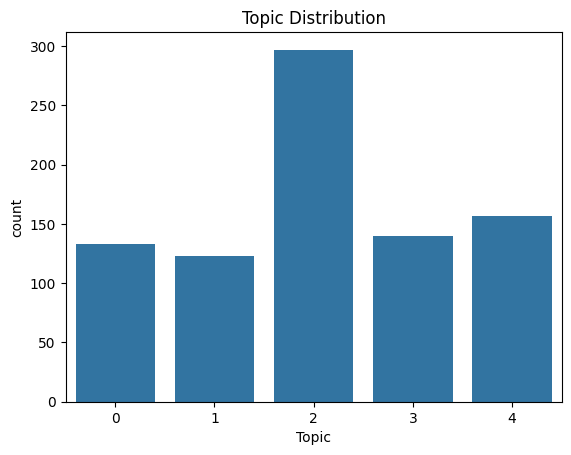

In [21]:
sns.countplot(x='Topic', data=df)
plt.title('Topic Distribution')
plt.show()

# Comprehensive Report Generation

In [22]:

def generate_report(df):
    sentiment_counts = df['Sentiment'].value_counts()
    avg_rating_per_sentiment = df.groupby('Sentiment')['Rating'].mean()

    print("Sentiment Analysis Report")
    print("-------------------------")
    print(f"Total Reviews: {len(df)}")
    print(f"Sentiment Counts: \n{sentiment_counts}")
    print(f"Average Rating per Sentiment: \n{avg_rating_per_sentiment}")

    print("\nTopic Analysis Report")
    print("---------------------")
    for i, topic in enumerate(LDA.components_):
        print(f'Top 10 words for topic #{i}:')
        print([vectorizer.get_feature_names_out()[i]
              for i in topic.argsort()[-10:]])
        print('\n')


generate_report(df)

Sentiment Analysis Report
-------------------------
Total Reviews: 850
Sentiment Counts: 
Sentiment
positive    434
negative    335
neutral      81
Name: count, dtype: int64
Average Rating per Sentiment: 
Sentiment
negative    1.314488
neutral     1.702703
positive    2.296104
Name: Rating, dtype: float64

Topic Analysis Report
---------------------
Top 10 words for topic #0:
['went', 'location', 'store', 'said', 'cup', 'time', 'order', 'drink', 'starbucks', 'coffee']


Top 10 words for topic #1:
['morning', 'drink', 'told', 'manager', 'asked', 'customer', 'went', 'store', 'starbucks', 'coffee']


Top 10 words for topic #2:
['store', 'customers', 'dont', 'time', 'like', 'service', 'coffee', 'customer', 'card', 'starbucks']


Top 10 words for topic #3:
['drinks', 'really', 'food', 'coffee', 'text', 'service', 'review', 'like', 'store', 'starbucks']


Top 10 words for topic #4:
['service', 'milk', 'order', 'time', 'asked', 'ordered', 'said', 'drink', 'coffee', 'starbucks']


